In [1]:
!pip install sentence_transformers
!pip install pymystem3

# Core
import time
import pandas as pd
import numpy as np 
from functools import reduce
from tqdm import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt

# NLP
import re
import gensim
import nltk
import spacy
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from pymystem3 import Mystem
from string import punctuation
from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords
from nltk import tokenize
from sentence_transformers import SentenceTransformer

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 557.2 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=1c01cb59305205f056f836e43ef88186036fdc831537b3894ac83b5c8116b241
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence_transformers


In [2]:
train = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
test = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
target_columns = ["toxic", "severe_toxic",
                  "obscene", "threat",
                  "insult", "identity_hate"]

In [5]:
test = test.merge(test_labels, on="id")

In [6]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [7]:
closed_test = test[(test[target_columns] == -1).any(axis=1)].reset_index(drop=True)
test = test[~(test[target_columns] == -1).any(axis=1)].reset_index(drop=True)

In [8]:
for data in [train, test]:
    print(train.isnull().sum(), '\n')

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 



In [9]:
print("Train")
for col in target_columns:
    print(train[col].value_counts(normalize=True))

Train
0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


In [10]:
print("Test")
for col in target_columns:
    print(test[col].value_counts(normalize=True))

Test
0    0.904811
1    0.095189
Name: toxic, dtype: float64
0    0.994264
1    0.005736
Name: severe_toxic, dtype: float64
0    0.942308
1    0.057692
Name: obscene, dtype: float64
0    0.996702
1    0.003298
Name: threat, dtype: float64
0    0.946435
1    0.053565
Name: insult, dtype: float64
0    0.988871
1    0.011129
Name: identity_hate, dtype: float64


In [11]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
mystem = Mystem()

def preprocess(text, stemming=True):
    if stemming:
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in stop_words\
                  and token != " "\
                  and token.strip() not in punctuation]
    else:
        tokens = gensim.utils.simple_preprocess(text)
        tokens = [token for token in tokens if (token not in\
                    gensim.parsing.preprocessing.STOPWORDS and 
                    token not in stop_words)]
        
    text = " ".join(tokens)
    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [12]:
def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

In [13]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2', device="cuda")
train['light_clean_comment_text'] = train['comment_text'].apply(process_text)
test['light_clean_comment_text'] = test['comment_text'].apply(process_text)
train_embs = sent_tr.encode(train["light_clean_comment_text"].to_list())
test_embs = sent_tr.encode(test["light_clean_comment_text"].to_list())

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/4987 [00:00<?, ?it/s]

Batches:   0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "True"

In [14]:
train['comment_text'] = train['comment_text'].apply(preprocess)
test['comment_text'] = test['comment_text'].apply(preprocess)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
def compute_metric(y_true, y_pred, verbose=True):
    assert y_true.shape == y_pred.shape
    roc_aucs = [roc_auc_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]
    if verbose:
        for metric, col in zip(roc_aucs, target_columns):
            print(f"{col} Roc Auc: {metric}")
        print(f"Result Roc Auc: {np.mean(roc_aucs)}")
    return roc_aucs, np.mean(roc_aucs)

In [111]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lof_reg", MultiOutputClassifier(LogisticRegression()))
])

all_train_pred = model.fit(
    train_embs, 
    train[target_columns]
).predict_proba(train_embs)
all_train_pred = np.stack([el[:,1] for el in all_train_pred],axis=1)
compute_metric(train[target_columns].values, all_train_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


toxic Roc Auc: 0.963098929997602
severe_toxic Roc Auc: 0.9891832087346946
obscene Roc Auc: 0.9761908008226293
threat Roc Auc: 0.9920272022151091
insult Roc Auc: 0.9747059520288451
identity_hate Roc Auc: 0.9863652058337915
Result Roc Auc: 0.980261883272112


([0.963098929997602,
  0.9891832087346946,
  0.9761908008226293,
  0.9920272022151091,
  0.9747059520288451,
  0.9863652058337915],
 0.980261883272112)

In [16]:
FOLDS = 5

In [17]:
train["stratified_target"] = train[target_columns].apply(
    lambda x: reduce(lambda x, y: str(x) + str(y), x), axis=1)

small_groups = train["stratified_target"].value_counts()[
    train["stratified_target"].value_counts() < FOLDS].index

train.loc[train["stratified_target"].isin(small_groups), "stratified_target"] = "-1"
train["stratified_target"].value_counts()

000000    143346
100000      5666
101010      3800
101000      1758
100010      1215
111010       989
101011       618
001000       317
000010       301
111011       265
001010       181
111000       158
100001       136
100011       134
101110       131
100100       113
111110        64
101111        56
000001        54
110000        41
101001        35
111111        31
000011        28
-1            22
000100        22
001011        18
100110        16
110010        14
101100        11
110100        11
110011         7
100101         7
111001         6
Name: stratified_target, dtype: int64

In [18]:
stratifier = StratifiedKFold(n_splits=FOLDS, random_state=69, shuffle=True)
classifier = MultiOutputClassifier(LogisticRegression(max_iter=1000))
#vectorizer = CountVectorizer()
#vectorizer = CountVectorizer(ngram_range=(1,2))
vectorizer = TfidfVectorizer()
#vectorizer = TfidfVectorizer(ngram_range=(1,2))
#!python3 -m spacy download ru_core_news_md
#spacy_nlp = spacy.load('ru_core_news_md')
#vectorizer = CountVectorizer(token_pattern = None, tokenizer=Tokenizer(spacy_nlp.vocab))

pipeline = Pipeline([("vectorizer", vectorizer),
         ("classifier", classifier)])

In [19]:
def fit_ensemble(X, y, stratifier, pipeline, verbose=True):
    all_train_preds = []
    all_test_preds = []
    all_train_targets = []
    all_test_targets = []
    all_models = []
    
    folds_ids = [el for el in stratifier.split(train, train["stratified_target"])]
    
    start = time.time()
    for fold_id, (train_ids, test_ids) in enumerate(folds_ids):
        model = pipeline
        model.fit(X.iloc[train_ids], y.iloc[train_ids])

        fold_train_preds = model.predict_proba(X.iloc[train_ids])
        fold_train_preds = np.stack([el[:,1] for el in fold_train_preds],axis=1)
        fold_test_preds = model.predict_proba(X.iloc[test_ids])
        fold_test_preds = np.stack([el[:,1] for el in fold_test_preds],axis=1)
        fold_train_targets = y.iloc[train_ids].values
        fold_test_targets = y.iloc[test_ids].values

        if verbose:
            print(f"Fold {fold_id + 1}")
            print("Train ROC AUC: ")
            compute_metric(fold_train_targets, fold_train_preds)
            print("Test: ROC AUC")
            compute_metric(fold_test_targets, fold_test_preds)
        
        all_train_preds.append(fold_train_preds)
        all_test_preds.append(fold_test_preds)
        all_train_targets.append(fold_train_targets)
        all_test_targets.append(fold_test_targets)
        all_models.append(model)

    stop = time.time()
    print('Training time (mins):', np.round((stop - start) / 60, 2))
    
    return [(all_train_preds, all_test_preds),
            (all_train_targets, all_test_targets),
            all_models]

In [120]:
predictions, targets, models = fit_ensemble(train["comment_text"],
                                           train[target_columns],
                                           stratifier,
                                           pipeline)

Fold 1
Train ROC AUC: 
toxic Roc Auc: 0.9854755452265939
severe_toxic Roc Auc: 0.9928910781089624
obscene Roc Auc: 0.994067854129991
threat Roc Auc: 0.9954363432369295
insult Roc Auc: 0.9884831563956413
identity_hate Roc Auc: 0.9909849681863162
Result Roc Auc: 0.9912231575474056
Test: ROC AUC
toxic Roc Auc: 0.96801805957741
severe_toxic Roc Auc: 0.9858680675026917
obscene Roc Auc: 0.9823202410011153
threat Roc Auc: 0.9830770121406597
insult Roc Auc: 0.9760131198551389
identity_hate Roc Auc: 0.9786586097246054
Result Roc Auc: 0.9789925183002701
Fold 2
Train ROC AUC: 
toxic Roc Auc: 0.9854234761788154
severe_toxic Roc Auc: 0.9930033285330717
obscene Roc Auc: 0.9936980562406464
threat Roc Auc: 0.9951787530365928
insult Roc Auc: 0.988075970529558
identity_hate Roc Auc: 0.9909377656139388
Result Roc Auc: 0.9910528916887706
Test: ROC AUC
toxic Roc Auc: 0.9698940475732587
severe_toxic Roc Auc: 0.9844708449389126
obscene Roc Auc: 0.9858473820531921
threat Roc Auc: 0.9735071853489382
insult Roc

In [121]:
all_train_preds = np.concatenate(predictions[0])
all_test_preds = np.concatenate(predictions[1])
all_train_targets = np.concatenate(targets[0])
all_test_targets = np.concatenate(targets[1])

print("OOF Train ROC AUC: ")
compute_metric(all_train_targets, all_train_preds);
print("OOF Test ROC AUC: ")
compute_metric(all_test_targets, all_test_preds);

OOF Train ROC AUC: 
toxic Roc Auc: 0.9854326124013926
severe_toxic Roc Auc: 0.9929076199999747
obscene Roc Auc: 0.9938230375989477
threat Roc Auc: 0.9952140610330102
insult Roc Auc: 0.9882953710332669
identity_hate Roc Auc: 0.9910162048821358
Result Roc Auc: 0.9911148178247879
OOF Test ROC AUC: 
toxic Roc Auc: 0.9697342145447392
severe_toxic Roc Auc: 0.985968746810158
obscene Roc Auc: 0.9848553238394163
threat Roc Auc: 0.9801783394134328
insult Roc Auc: 0.9763703520530419
identity_hate Roc Auc: 0.9755546866094963
Result Roc Auc: 0.9787769438783807


In [122]:
test_pred = []
for m in models:
    fold_test_pred = m.predict_proba(test["comment_text"])
    fold_test_pred = np.stack([el[:,1] for el in fold_test_pred],axis=1)
    test_pred.append(fold_test_pred)

In [123]:
compute_metric(
    test[target_columns].values, 
    np.stack(test_pred,axis=0).mean(0)
);

toxic Roc Auc: 0.9591784296565884
severe_toxic Roc Auc: 0.9845410436398654
obscene Roc Auc: 0.9738903454390884
threat Roc Auc: 0.9852391002581451
insult Roc Auc: 0.9656663213487141
identity_hate Roc Auc: 0.9785895747116597
Result Roc Auc: 0.9745174691756769


# Logistic regression ensemble (5)

## Rough preprocess

- CountVectorizer()
- Result **Roc Auc**: 0.9425116547815806

- CountVectorizer()
- Result **Roc Auc**: 0.9560571239783178

- TfidfVectorizer(n_grams=(1,2))
- Result **Roc Auc**: 0.9723529161153364

- TfidfVectorizer()
- Result **Roc Auc**: 0.9745174691756769

## Lemmatization

- CountVactorizer()
- Result **Roc Auc**: 0.9425116547815806

- TfidfVectorizer()
- Result **Roc Auc**: 0.9745174691756769

## Light clean

- SentenceTransformer()
- Result **Roc Auc**: 0.980261883272112

# PyTorch RNN model

In [20]:
class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Linear(
            rnn_channels * 2 if bidirectional else rnn_channels, 
            out_channels, 
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimensions [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x

In [21]:
nn_model = UniversalRNN(128, 2)
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=1024, out_features=2, bias=True)
)

In [22]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train["light_clean_comment_text"]), 
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

In [23]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        trim_policy="random"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequance(self, input):
        if len(input) < self.max_length:
            return input + [0] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))
        # In order to form batch, which is a tensor - we have to get sequnces of same length
        text_ids = self.select_text_subsequance(text_ids)
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(self.targets[idx]).float()
        )
    
    def __len__(self):
        return len(self.texts)

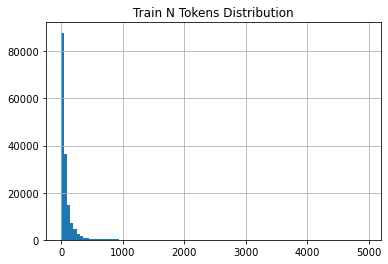

0.95 Quantile of N tokens: 266.5


In [24]:
train_n_tokens = train["light_clean_comment_text"].apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

In [25]:
max_tokens = 300

train_torch_dataset = TextDataset(
    texts=train["light_clean_comment_text"].to_list(),
    targets=train[target_columns].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=max_tokens,
    # trim_policy="first"
)

In [26]:
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

In [27]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cuda"
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path
            predicted_label = inp_model(text)
            # 1.2 Compute Cost function (part of Forward path)
            loss = criterion(predicted_label, label)
            if mode == "train":
                # 2. Compute Backward path
                loss.mean().backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                # 3. Apply gradient descent `on steroids` 
                optimizer.step()
                
            # Accumulate stats
            # We receive logits and we have to transform them into `probs`. That is why sigmoid is used
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
    all_predicted_label = np.concatenate(all_predicted_label)
    all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets

def print_losses(input):
    for cls_idx, cls_name in enumerate(target_columns):
        print(f"{cls_name} BCE loss: {input[:,cls_idx].mean()}")
    print(f"Result BCE loss: {input.mean()}")

In [28]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    out_channels=len(target_columns),
    average_type="mean"
).to("cuda")

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.25, min_lr=1e-7, mode="max", verbose=True)

In [29]:
folds_ids = [el for el in stratifier.split(train, train["stratified_target"])]

train_torch_dataset = TextDataset(
    texts=train.iloc[folds_ids[0][0]]["light_clean_comment_text"].to_list(),
    targets=train.iloc[folds_ids[0][0]][target_columns].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=max_tokens,
)
# TODO: Read more about DataLoader : https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=2
)

valid_torch_dataset = TextDataset(
    texts=train.iloc[folds_ids[0][1]]["light_clean_comment_text"].to_list(),
    targets=train.iloc[folds_ids[0][1]][target_columns].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=max_tokens,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=2
)

In [30]:
n_epochs = 3

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(n_epochs):
    print(f"Starting Epoch {epoch+1}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="train"
    )
    # 1.2 Compute and print train metrics
    print("Train metrics")
    _, train_roc_auc = compute_metric(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("Train BCE losses")
    print_losses(train_epoch_losses)
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    print("Valid metrics")
    _, valid_roc_auc = compute_metric(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("Valid BCE losses")
    print_losses(valid_epoch_losses)
    # 3. Update learning rate (if needed)
    scheduler.step(valid_roc_auc)
    # 4. Save best model
    if valid_roc_auc > best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)

Starting Epoch 1
Train phase


100%|██████████| 3989/3989 [05:49<00:00, 11.43it/s]


Train metrics
toxic Roc Auc: 0.9545827644740614
severe_toxic Roc Auc: 0.9806742820891934
obscene Roc Auc: 0.9770711815161492
threat Roc Auc: 0.933741902214895
insult Roc Auc: 0.9690188611117245
identity_hate Roc Auc: 0.941989843235765
Result Roc Auc: 0.9595131391069648
Train BCE losses
toxic BCE loss: 0.12947537004947662
severe_toxic BCE loss: 0.027716191485524178
obscene BCE loss: 0.06740282475948334
threat BCE loss: 0.014344344846904278
insult BCE loss: 0.08087243139743805
identity_hate BCE loss: 0.03303668275475502
Result BCE loss: 0.05880798399448395
Valid phase


100%|██████████| 998/998 [00:22<00:00, 43.62it/s]


Valid metrics
toxic Roc Auc: 0.9732676557505552
severe_toxic Roc Auc: 0.9899304245091142
obscene Roc Auc: 0.9873646847586743
threat Roc Auc: 0.9759456151377817
insult Roc Auc: 0.9822594576940488
identity_hate Roc Auc: 0.9658606809972438
Result Roc Auc: 0.9791047531412364
Valid BCE losses
toxic BCE loss: 0.10355691611766815
severe_toxic BCE loss: 0.027325501665472984
obscene BCE loss: 0.05446004495024681
threat BCE loss: 0.012776682153344154
insult BCE loss: 0.06560680270195007
identity_hate BCE loss: 0.02639257349073887
Result BCE loss: 0.04835309460759163
Starting Epoch 2
Train phase


100%|██████████| 3989/3989 [05:47<00:00, 11.47it/s]


Train metrics
toxic Roc Auc: 0.9864978546009157
severe_toxic Roc Auc: 0.9902445071031964
obscene Roc Auc: 0.9930667420078062
threat Roc Auc: 0.9883975336976114
insult Roc Auc: 0.9890589447969315
identity_hate Roc Auc: 0.985537405364262
Result Roc Auc: 0.9888004979284539
Train BCE losses
toxic BCE loss: 0.07721507549285889
severe_toxic BCE loss: 0.022248338907957077
obscene BCE loss: 0.0429239422082901
threat BCE loss: 0.008313330821692944
insult BCE loss: 0.05475374683737755
identity_hate BCE loss: 0.02160988561809063
Result BCE loss: 0.037844058126211166
Valid phase


100%|██████████| 998/998 [00:22<00:00, 43.87it/s]


Valid metrics
toxic Roc Auc: 0.972556625483865
severe_toxic Roc Auc: 0.9907807960294962
obscene Roc Auc: 0.9858609938150166
threat Roc Auc: 0.9806229117734625
insult Roc Auc: 0.981726834954584
identity_hate Roc Auc: 0.9715815448137136
Result Roc Auc: 0.9805216178116897
Valid BCE losses
toxic BCE loss: 0.10659496486186981
severe_toxic BCE loss: 0.02150190807878971
obscene BCE loss: 0.05781523883342743
threat BCE loss: 0.011709840036928654
insult BCE loss: 0.06574557721614838
identity_hate BCE loss: 0.025107108056545258
Result BCE loss: 0.04807910695672035
Starting Epoch 3
Train phase


100%|██████████| 3989/3989 [05:47<00:00, 11.48it/s]


Train metrics
toxic Roc Auc: 0.9952610803090485
severe_toxic Roc Auc: 0.9938784875265512
obscene Roc Auc: 0.9970413454734766
threat Roc Auc: 0.9966416163144705
insult Roc Auc: 0.9946014966433362
identity_hate Roc Auc: 0.9943863810751925
Result Roc Auc: 0.9953017345570125
Train BCE losses
toxic BCE loss: 0.049082495272159576
severe_toxic BCE loss: 0.01837739534676075
obscene BCE loss: 0.030107667669653893
threat BCE loss: 0.00533946743234992
insult BCE loss: 0.04016951099038124
identity_hate BCE loss: 0.014325340278446674
Result BCE loss: 0.026233643293380737
Valid phase


100%|██████████| 998/998 [00:22<00:00, 44.93it/s]

Valid metrics
toxic Roc Auc: 0.9706222477216172
severe_toxic Roc Auc: 0.9891670645187022
obscene Roc Auc: 0.9860102052597098
threat Roc Auc: 0.9785540375136458
insult Roc Auc: 0.9795617416422061
identity_hate Roc Auc: 0.9677106881605148
Result Roc Auc: 0.9786043308027326
Valid BCE losses
toxic BCE loss: 0.12304869294166565
severe_toxic BCE loss: 0.02578885853290558
obscene BCE loss: 0.06063735485076904
threat BCE loss: 0.011594894342124462
insult BCE loss: 0.0741572305560112
identity_hate BCE loss: 0.027438748627901077
Result BCE loss: 0.053777627646923065


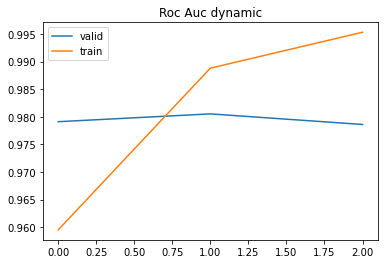

In [31]:
plt.title("Roc Auc dynamic")
plt.plot(valid_roc_aucs, label="valid")
plt.plot(train_roc_aucs, label="train")
plt.legend()
plt.show()

In [32]:
# Load best model
nn_model.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=test["light_clean_comment_text"].to_list(),
    targets=test[target_columns].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=max_tokens,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True
)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device="cuda",
    mode="eval"
)

100%|██████████| 2000/2000 [00:44<00:00, 44.51it/s]


In [33]:
print("Test metrics")
compute_metric(
    test_targets, 
    test_labels
);
print("Test BCE losses")
print_losses(test_losses)

Test metrics
toxic Roc Auc: 0.9628554667253951
severe_toxic Roc Auc: 0.9861633017475899
obscene Roc Auc: 0.9735523478170661
threat Roc Auc: 0.9851335248431474
insult Roc Auc: 0.9710565015196959
identity_hate Roc Auc: 0.9729987586743611
Result Roc Auc: 0.975293316887876
Test BCE losses
toxic BCE loss: 0.19596286118030548
severe_toxic BCE loss: 0.017703311517834663
obscene BCE loss: 0.11141855269670486
threat BCE loss: 0.010363269597291946
insult BCE loss: 0.08656776696443558
identity_hate BCE loss: 0.02799474634230137
Result BCE loss: 0.07500174641609192


## Gradient clipping, Adam,  scheduler patience 1, factor 0.5,  3 epochs

- Test metrics
- Result Roc Auc: 0.9704846301749726
- Result BCE loss: 0.07693787664175034

## Adam, scheduler patience 1, factor 0.5, 3 epochs
- Test metrics
- Result Roc Auc: 0.971751481642006
- Result BCE loss: 0.06823492050170898

## Adam + AMSGrad, scheduler patience 1, factor 0.5, 3 epochs

- Test metrics
- Result Roc Auc: 0.9723275500704003
- Result BCE loss: 0.06821506470441818

## Adam + AMSGrad, scheduler patience 10, factor 0.5, 3 epochs
- Test metrics
- Result Roc Auc: 0.9740753446181679
- Result BCE loss: 0.0792461559176445

# Best
## Adam + AMSGrad, scheduler patience 10, factor 0.25, 3 epochs
- Test metrics
- Result Roc Auc: 0.9752403365208738
- Result BCE loss: 0.06853504478931427
    